# Imports

In [1]:
# Import utils
import numpy as np
import pandas as pd
import copy
import time
import datetime as dt
import pickle
import json
from pathlib import Path
import joblib
from joblib import dump, load, Parallel, delayed
import os
import itertools
import contextlib
from tqdm import tqdm

from Experiment import Evaluation

In [2]:
# Setup the experiment
experiment_setup = dict(

    # Set paths
    path_data = '/home/fesc/DDDInventoryControl/Data',
    path_weightsmodel = '/home/fesc/DDDInventoryControl/Data/WeightsModel',
    path_results = '/home/fesc/DDDInventoryControl/Data/Results',
    
    # Weights models
    global_weightsmodel = 'rfwm_global', 
    local_weightsmodel = 'rfwm_local', 

    # Optimization models
    GwSAA = 'GwSAA',
    GwSAAR = 'GwSAAR',
    wSAA = 'wSAA',
    wSAAR = 'wSAAR',
    SAA = 'SAA',
    ExPost = 'ExPost',
    
    # Set identifier of start period of testing horizon
    timePeriodsTestStart = 114,

    # Set product identifiers
    products = range(1,460+1),   # Products (SKUs) k=1,...,M
    
    # Set problem params
    T = 13,             # Planning horizon T
    ts = range(1,13+1), # Periods t=1,...,T of the planning horizon
    taus = [0,1,2,3,4], # Look-aheads tau=0,...,4
    es = [1,3,6,9,12],  # Uncertainty set specifications e=1,...,12
       
    # Set cost params
    cost_params = [
        {'CR': 0.50, 'K': 100, 'u': 0.5, 'h': 1, 'b': 1},
        {'CR': 0.75, 'K': 100, 'u': 0.5, 'h': 1, 'b': 3},
        {'CR': 0.90, 'K': 100, 'u': 0.5, 'h': 1, 'b': 9}
    ]
)

# Make all experiment variables visible locally
locals().update(experiment_setup)

# Initialize Evaluation
evaluation = Evaluation()

# Experiment post-processing

## Concatenate and aggregate results per model

Concatenate all results per model (for different $\tau=0,...,4$ and different $e=\{1,3,6,9,12\}$ for robust models). Aggregate over periods $t=1,...,T$ for each cost parameter setting, look-ahead, uncertainty parameter, and product.

In [ ]:
# Rolling Horizon Global Weighted SAA (GwSAA)
results = evaluation.concatenate_results(path_results+'/'+GwSAA, GwSAA, products, taus)
results.to_csv(path_results+'/'+GwSAA+'_results.csv', sep=',', index=False)
results_agg = evaluation.aggregate_results(results, ['CR', 'tau', 'product'])
results_agg.to_csv(path_results+'/'+GwSAA+'_results_summary.csv', sep=',', index=False)

In [ ]:
# Rolling Horizon Local Weighted SAA (wSAA)
results = evaluation.concatenate_results(path_results+'/'+wSAA, wSAA, products, taus)
results.to_csv(path_results+'/'+wSAA+'_results.csv', sep=',', index=False)
results_agg = evaluation.aggregate_results(results, ['CR', 'tau', 'product'])
results_agg.to_csv(path_results+'/'+wSAA+'_results_summary.csv', sep=',', index=False)

In [ ]:
# Rolling Horizon Global Robust Weighted SAA (GwSAA-R)
results = evaluation.concatenate_results(path_results+'/'+GwSAAR, GwSAAR, products, taus, es)
results.to_csv(path_results+'/'+GwSAAR+'_results.csv', sep=',', index=False)
results_agg = evaluation.aggregate_results(results, ['CR', 'tau', 'e', 'product'])
results_agg.to_csv(path_results+'/'+GwSAAR+'_results_summary.csv', sep=',', index=False)

In [ ]:
# Rolling Horizon Local Robust Weighted SAA (wSAA-R)
results = evaluation.concatenate_results(path_results+'/'+wSAAR, wSAAR, products, taus, es)
results.to_csv(path_results+'/'+wSAAR+'_results.csv', sep=',', index=False)
results_agg = evaluation.aggregate_results(results, ['CR', 'tau', 'e', 'product'])
results_agg.to_csv(path_results+'/'+wSAAR+'_results_summary.csv', sep=',', index=False)

In [ ]:
# Rolling Horizon Local SAA (SAA)
results = evaluation.concatenate_results(path_results+'/'+SAA, SAA, products, taus)
results.to_csv(path_results+'/'+SAA+'_results.csv', sep=',', index=False)
results_agg = evaluation.aggregate_results(results, ['CR', 'tau', 'product'])
results_agg.to_csv(path_results+'/'+SAA+'_results_summary.csv', sep=',', index=False)

In [ ]:
# Ex-post Clairvoyant (ExPost)
results = evaluation.concatenate_results(path_results+'/'+ExPost, ExPost, products, taus=[None])
results.to_csv(path_results+'/'+ExPost+'_results.csv', sep=',', index=False)
results_agg = evaluation.aggregate_results(results, ['CR', 'product'])
results_agg.to_csv(path_results+'/'+ExPost+'_results_summary.csv', sep=',', index=False)

## Select ex-post best model parameters per model

For each model we select the ex-post best model parameters $\tau$ and $e$ that minimize cost over the test planning horizon for our empirical evaluation. That is, for a given model we select the ex-post best $\tau$ and $e$ for each product and for each cost paramater setting.

In [ ]:
# Load aggregated results
results_GwSAA = pd.read_csv(path_results+'/'+GwSAA+'_results_summary.csv')
results_wSAA = pd.read_csv(path_results+'/'+wSAA+'_results_summary.csv')
results_GwSAAR = pd.read_csv(path_results+'/'+GwSAAR+'_results_summary.csv')
results_wSAAR = pd.read_csv(path_results+'/'+wSAAR+'_results_summary.csv')
results_SAA = pd.read_csv(path_results+'/'+SAA+'_results_summary.csv')
results_ExPost = pd.read_csv(path_results+'/'+ExPost+'_results_summary.csv')

In [ ]:
# Find best tau
results_GwSAA_best = evaluation.best_tau(results_GwSAA, results_ExPost, groupby=['CR', 'product'])
results_wSAA_best = evaluation.best_tau(results_wSAA, results_ExPost, groupby=['CR', 'product'])
results_GwSAAR_best = evaluation.best_tau(results_GwSAAR, results_ExPost, groupby=['CR', 'product', 'e'])
results_wSAAR_best = evaluation.best_tau(results_wSAAR, results_ExPost, groupby=['CR', 'product', 'e'])
results_SAA_best = evaluation.best_tau(results_SAA, results_ExPost, groupby=['CR', 'product'])

In [ ]:
# Find best e given best tau for robust models
results_GwSAAR_best = evaluation.best_e(results_GwSAAR_best, results_ExPost, groupby=['CR', 'product'])
results_wSAAR_best = evaluation.best_e(results_wSAAR_best, results_ExPost, groupby=['CR', 'product'])

In [ ]:
# Combine to one results data set
cols = ['model', 'CR', 'tau', 'e', 'product', 'K', 'u', 'h', 'b', 
        'I', 'q', 'I_q', 'y', 'I_q_y', 'c_o', 'c_s', 'cost',
       'defaulted', 'solutions', 'gap', 'exec_time_sec', 'cpu_time_sec']

results_GwSAA_best['model'] = copy.deepcopy(GwSAA)
results_GwSAA_best['e'] = None
results_GwSAA_best = results_GwSAA_best[cols]

results_wSAA_best['model'] = copy.deepcopy(wSAA)
results_wSAA_best['e'] = None
results_wSAA_best = results_wSAA_best[cols]

results_GwSAAR_best['model'] = copy.deepcopy(GwSAAR)
results_GwSAAR_best = results_GwSAAR_best[cols]

results_wSAAR_best['model'] = copy.deepcopy(wSAAR) 
results_wSAAR_best = results_wSAAR_best[cols]

results = pd.concat([results_GwSAA_best, results_wSAA_best, results_GwSAAR_best, results_wSAAR_best])

In [ ]:
# Add SAA and ExPost
results = pd.merge(left=results,
                   right=results_SAA_best[['CR', 'product', 'cost']],
                   on=['CR', 'product'],
                   suffixes=('', '_SAA'))
results = pd.merge(left=results,
                   right=results_ExPost[['CR', 'product', 'cost']],
                   on=['CR', 'product'],
                   suffixes=('', '_ExPost'))

In [ ]:
# Save
results.to_csv(path_results+'/Results_summary.csv', sep=',', index=False)

# Empirical Evaluation

In [ ]:
# Load
results = pd.read_csv(path_results+'/Results_summary.csv')

In [ ]:
## Total relative cost

In [ ]:
results_total = results.groupby(['CR', 'model']).agg({'cost': sum, 'cost_SAA': sum}).reset_index()
results_total['relTotalCost'] = results_total.cost / results_total.cost_SAA
results_total['diffToSAAinPercent'] = np.around((results_total.relTotalCost - 1)*100, 1)
results_total[['CR', 'model', 'relTotalCost', 'diffToSAAinPercent']]

In [ ]:
## Per product relative cost

In [ ]:
results_perProduct = copy.deepcopy(results)
results_perProduct['medianRelCost'] = (
    (results_perProduct.cost == results_perProduct.cost_SAA) * 1  
    + (results_perProduct.cost != results_perProduct.cost_SAA) * (results_perProduct.cost / results_perProduct.cost_SAA)
)
results_perProduct = results_perProduct.groupby(['CR', 'model']).agg({'medianRelCost': np.median}).reset_index()
results_perProduct['diffToSAAinPercent'] = np.around((results_perProduct.medianRelCost - 1)*100, 1)
results_perProduct[['CR', 'model', 'medianRelCost', 'diffToSAAinPercent']]

## Total relative costs and relative costs per product

### Total relative cost

### Per product relative cost

### Achieved service level

### Differences of per product relative costs

### Statistical significance of differences of per product relative costs

## Ex-post model selection

### Frequency of selected model

### Differences to model selection

## CV model selection

In [ ]:
# TBD

## Structural Insights: From Predictive To Prescriptive Performance

In [ ]:
### RMSSE

In [ ]:
### SPL

In [ ]:
# For each look-ahead tau=0,...,4
for tau in taus:

    # Print:
    print('...look-ahead tau='+str(tau)+'...')

    # Initialize Experiment
    experiment = Experiment(global_weightsmodel+'_for_model_cv', GwSAAR+'_for_model_cv_maxnorm', **experiment_setup)

    # Load preprocessed data (alternatively, data can be preprocessed here)
    data = load(path_weightsmodel+'/global_data_for_model_cv_tau'+str(tau)+'.joblib')

    # Load weights
    weights = load(path_weightsmodel+'/'+global_weightsmodel+'_weights_for_model_cv_tau'+str(tau)+'.joblib') 

    # Preprocess experiment data
    weights_, samples_, actuals_, epsilons_ = experiment.preprocess_data(data, weights, e, maxnorm=True)


In [3]:
def getWassersteinDistances(densities, yTest, p):
    
    wassersteinDists = list()
    
    for i in range(len(yTest)):
        y = yTest[i]
        values = densities[i][1]
        probs = densities[i][0]

        if len(values.shape) == 1:
            values = values.reshape(-1, 1)
            y = y.reshape(-1, 1)

        wassersteinDists.append(np.sum(probs * np.sum(np.abs(values - y)**p, axis = 1))**(1/p))

    return np.array(wassersteinDists)

In [ ]:
from Experiment import Experiment

In [ ]:
tau=2

In [4]:
## GwSAA

# Initialize Experiment
experiment = Experiment(global_weightsmodel, GwSAA, **experiment_setup)

# Load preprocessed data (alternatively, data can be preprocessed here)
data = load(path_weightsmodel+'/global_data_tau'+str(tau)+'.joblib')

# Load weights
weights = load(path_weightsmodel+'/'+global_weightsmodel+'_weights_tau'+str(tau)+'.joblib') 

In [5]:
# Preprocess experiment data
weights_, samples_, actuals_ = experiment.preprocess_data(data, weights)

In [6]:
W1 = {}
for product in products:
    
    densities = [(weights_[product][w], samples_[product][s]) for (w,s) in zip(weights_[product], samples_[product])]
    
    yTest = [actuals_[product][a] for a in actuals_[product]]
    
    W1[product] = getWassersteinDistances(densities, yTest, 1)

In [7]:
## SAA

# Initialize Experiment
experiment = Experiment(local_weightsmodel, SAA, **experiment_setup)

# Load preprocessed data (alternatively, data can be preprocessed here)
data = load(path_weightsmodel+'/local_data_tau'+str(tau)+'.joblib')

In [8]:
# Preprocess experiment data
samples_, actuals_ = experiment.preprocess_data(data)

In [9]:
W1_SAA = {}
for product in products:
    
    densities = [(1/len(samples_[product][w]), samples_[product][s]) for (w,s) in zip(samples_[product], samples_[product])]
    
    yTest = [actuals_[product][a] for a in actuals_[product]]
    
    W1_SAA[product] = getWassersteinDistances(densities, yTest, 1)

In [13]:
## Normalize
W1_normalized = {}
W1_normalized_median = {}
W1_normalized_mean = {}

for product in products:
    
    W1_normalized[product] = W1[product] / W1_SAA[product]
    
    W1_normalized_median[product] = np.median(W1[product] / W1_SAA[product])
    
    W1_normalized_mean[product] = np.mean(W1[product] / W1_SAA[product])

In [17]:
w = np.array([W1_normalized_mean[w] for w in W1_normalized_mean])

In [18]:
import matplotlib.pyplot as plt

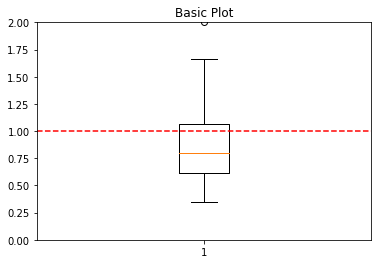

In [27]:
fig1, ax1 = plt.subplots()
ax1.set_title('Basic Plot')
ax1.boxplot(w)
ax1.set_ylim((0,2))
plt.axhline(y = 1, color = 'r', linestyle = '--')

In [32]:
np.median(w), sum(w<1)/len(w)

(0.8028399780472102, 0.6869565217391305)

In [29]:
## wSAA

# Initialize Experiment
experiment = Experiment(global_weightsmodel, wSAA, **experiment_setup)

# Load preprocessed data (alternatively, data can be preprocessed here)
data = load(path_weightsmodel+'/local_data_tau'+str(tau)+'.joblib')

# Load weights
weights = load(path_weightsmodel+'/'+local_weightsmodel+'_weights_tau'+str(tau)+'.joblib') 

In [33]:
# Preprocess experiment data
weights_, samples_, actuals_ = experiment.preprocess_data(data, weights)

In [36]:
W1 = {}
for product in products:
    
    densities = [(weights_[product][w], samples_[product][s]) for (w,s) in zip(weights_[product], samples_[product])]
    
    yTest = [actuals_[product][a] for a in actuals_[product]]
    
    W1[product] = getWassersteinDistances(densities, yTest, 1)

In [37]:
## Normalize
W1_normalized = {}
W1_normalized_median = {}
W1_normalized_mean = {}

for product in products:
    
    W1_normalized[product] = W1[product] / W1_SAA[product]
    
    W1_normalized_median[product] = np.median(W1[product] / W1_SAA[product])
    
    W1_normalized_mean[product] = np.mean(W1[product] / W1_SAA[product])

In [38]:
w = np.array([W1_normalized_mean[w] for w in W1_normalized_mean])

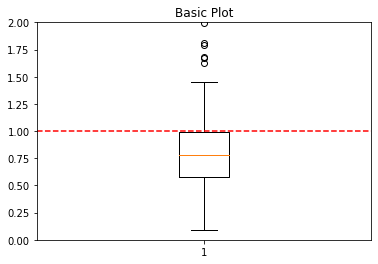

In [39]:
fig1, ax1 = plt.subplots()
ax1.set_title('Basic Plot')
ax1.boxplot(w)
ax1.set_ylim((0,2))
plt.axhline(y = 1, color = 'r', linestyle = '--')

In [40]:
np.median(w), sum(w<1)/len(w)

(0.7793374337176534, 0.7673913043478261)

In [ ]:
#####################################################################################################

In [44]:
### GwSAA

In [48]:
# Get best tau per product per CR
results_GwSAA = pd.read_csv(path_results+'/WithModelCV/GwSAA_for_model_cv_results_summary.csv')
results_ExPost = pd.read_csv(path_results+'/ExPost_results_summary.csv')

In [49]:
results_GwSAA_best = evaluation.best_tau(results_GwSAA, results_ExPost, groupby=['CR', 'product'])

In [50]:
W1 = {}
meta = {}

for tau in taus:   
    
    W1[tau] = {}
    meta[tau] = {}

    # Load preprocessed data (alternatively, data can be preprocessed here)
    data = load(path_weightsmodel+'/global_data_tau'+str(tau)+'.joblib')

    # Load weights
    weights = load(path_weightsmodel+'/'+global_weightsmodel+'_weights_tau'+str(tau)+'.joblib') 

    # Preprocess experiment data
    weights_, samples_, actuals_ = experiment.preprocess_data(data, weights)
    
    for cost_params_ in cost_params:
        
        W1[tau][cost_params_['CR']] = {}
        meta[tau][cost_params_['CR']] = {}
        
        which = (results_GwSAA_best.CR==cost_params_['CR']) & (results_GwSAA_best.tau==tau)
        products_ = list(results_GwSAA_best.loc[which]['product'])
        
        experiment_setup_ = copy.deepcopy(experiment_setup)

        experiment_setup_.update({'cost_params': [cost_params_]})

        # Initialize Experiment
        experiment = Experiment(global_weightsmodel, GwSAA, **experiment_setup_)
        
        for product in products_:
            
            densities = [(weights_[product][w], samples_[product][s]) for (w,s) in zip(weights_[product], samples_[product])]

            yTest = [actuals_[product][a] for a in actuals_[product]]

            W1[tau][cost_params_['CR']][product] = getWassersteinDistances(densities, yTest, 1)
            
            meta[tau][cost_params_['CR']][product] = {'CR': cost_params_['CR'], 'product': product, 'tau': tau}

In [51]:
W1_results_GwSAA = copy.deepcopy(W1)

In [72]:
# Restructure along CR and products
W1={}
OptTau={}
for CR in [0.50, 0.75, 0.90]:
    W1[CR]={}
    OptTau[CR]={}
    for tau in taus:
        for product in W1_results_GwSAA[tau][CR]:
            W1[CR][product] = W1_results_GwSAA[tau][CR][product]
            OptTau[CR][product] = copy.deepcopy(tau)
            
# Order
W1_ordered={}
OptTau_ordered={}
for CR in [0.50, 0.75, 0.90]:
    W1_ordered[CR]={}
    OptTau_ordered[CR]={}
    for product in products:
        W1_ordered[CR][product] = W1[CR][product]
        OptTau_ordered[CR][product] = OptTau[CR][product]

In [74]:
W1_results_GwSAA = copy.deepcopy(W1_ordered)

In [94]:
### GwSAA

In [104]:
W1 = {}
meta = {}

for tau in taus:   
    
    W1[tau] = {}
    meta[tau] = {}

    # Load preprocessed data (alternatively, data can be preprocessed here)
    data = load(path_weightsmodel+'/global_data_tau'+str(tau)+'.joblib')

    # Load weights
    weights = load(path_weightsmodel+'/'+global_weightsmodel+'_weights_tau'+str(tau)+'.joblib') 

    # Preprocess experiment data
    weights_, samples_, actuals_ = experiment.preprocess_data(data, weights)

    # Initialize Experiment
    experiment = Experiment(global_weightsmodel, GwSAA, **experiment_setup)

    for product in products:

        densities = [(weights_[product][w], samples_[product][s]) for (w,s) in zip(weights_[product], samples_[product])]

        yTest = [actuals_[product][a] for a in actuals_[product]]

        W1[tau][product] = getWassersteinDistances(densities, yTest, 1)

In [105]:
W1_results_GwSAA = copy.deepcopy(W1)

In [106]:
### wSAA

In [107]:
W1 = {}
meta = {}

for tau in taus:   
    
    W1[tau] = {}
    meta[tau] = {}

    # Load preprocessed data (alternatively, data can be preprocessed here)
    data = load(path_weightsmodel+'/local_data_tau'+str(tau)+'.joblib')

    # Load weights
    weights = load(path_weightsmodel+'/'+local_weightsmodel+'_weights_tau'+str(tau)+'.joblib') 

    # Preprocess experiment data
    weights_, samples_, actuals_ = experiment.preprocess_data(data, weights)

    # Initialize Experiment
    experiment = Experiment(local_weightsmodel, wSAA, **experiment_setup)
        
    for product in products:

        densities = [(weights_[product][w], samples_[product][s]) for (w,s) in zip(weights_[product], samples_[product])]

        yTest = [actuals_[product][a] for a in actuals_[product]]

        W1[tau][product] = getWassersteinDistances(densities, yTest, 1)

In [108]:
W1_results_wSAA = copy.deepcopy(W1)

In [109]:
### SAA

In [110]:
W1 = {}
meta = {}

for tau in taus:   
    
    W1[tau] = {}
    meta[tau] = {}

    # Load preprocessed data (alternatively, data can be preprocessed here)
    data = load(path_weightsmodel+'/local_data_tau'+str(tau)+'.joblib')

    # Preprocess experiment data
    samples_, actuals_ = experiment.preprocess_data(data)

    # Initialize Experiment
    experiment = Experiment(local_weightsmodel, SAA, **experiment_setup)
        
    for product in products:

        densities = [(1/len(samples_[product][s]), samples_[product][s]) for s in samples_[product]]

        yTest = [actuals_[product][a] for a in actuals_[product]]

        W1[tau][product] = getWassersteinDistances(densities, yTest, 1)

In [111]:
W1_results_SAA = copy.deepcopy(W1)

In [131]:
## Normalize -- by SAA with same tau
def normalize_W(W1, W1_SAA, taus, products):

    W1_normalized = {}
    W1_normalized_median = {}
    W1_normalized_mean = {}

    for tau in taus:
        W1_normalized[tau] = {}
        W1_normalized_median[tau] = {}
        W1_normalized_mean[tau] = {}
        for product in products:
            W1_normalized[tau][product] = W1[tau][product] / W1_SAA[tau][product]
            W1_normalized[tau][product][W1[tau][product] == W1_SAA[tau][product]] = 1.0
            
            #W1_normalized[tau][product][W1[tau][product] != W1_SAA[tau][product]] = (W1[tau][product] / W1_SAA[tau][product])[W1[tau][product] != W1_SAA[tau][product]]
            W1_normalized_median[tau][product] = np.median(W1_normalized[tau][product])
            W1_normalized_mean[tau][product] = np.mean(W1_normalized[tau][product])
            
    return W1_normalized, W1_normalized_median, W1_normalized_mean

In [132]:
res = normalize_W(W1_results_GwSAA, W1_results_SAA, taus, products)
W1_GwSAA_normalized, W1_GwSAA_normalized_median, W1_GwSAA_normalized_mean = res

res = normalize_W(W1_results_wSAA, W1_results_SAA, taus, products)
W1_wSAA_normalized, W1_wSAA_normalized_median, W1_wSAA_normalized_mean = res

/tmp/ipykernel_2883579/1426317698.py:13: RuntimeWarning: divide by zero encountered in divide
  W1_normalized[tau][product] = W1[tau][product] / W1_SAA[tau][product]
/tmp/ipykernel_2883579/1426317698.py:13: RuntimeWarning: invalid value encountered in divide
  W1_normalized[tau][product] = W1[tau][product] / W1_SAA[tau][product]


In [133]:
W1_wSAA_normalized_median

{0: {1: 0.4297550183363702,
  2: 0.32263689696831277,
  3: 0.2699288163784691,
  4: 0.4935969092364971,
  5: 0.3666091705756943,
  6: 0.7621946984285869,
  7: 0.30042442690047494,
  8: 0.39116331079821054,
  9: 0.21905209020221367,
  10: 0.6973183796728475,
  11: 0.8656636290181854,
  12: 0.2655939370542999,
  13: 0.6853375579982748,
  14: 0.6378137954542754,
  15: 0.8180425569724171,
  16: 0.3316471725774642,
  17: 0.216271544025289,
  18: 0.5360765581680099,
  19: 1.0301641656024345,
  20: 0.6973240695691539,
  21: 0.22286810890542183,
  22: 0.3739528635735301,
  23: 0.36121295657132674,
  24: 1.0028680514149235,
  25: 0.7547377000413674,
  26: 0.8885165076575445,
  27: 0.7656803123623522,
  28: 0.6960497490119568,
  29: 0.27982161503550873,
  30: 0.8762276372341041,
  31: 1.1030874457780653,
  32: 0.8291639923422212,
  33: 0.9015140656445003,
  34: 0.4802210229565861,
  35: 0.7342730913447295,
  36: 0.6277151776197004,
  37: 0.6023569413258448,
  38: 0.9474639474868009,
  39: 1.1564

In [ ]:
## Normalize -- by SAA with best tau of SAA

In [ ]:
#####################################################################################################

## Practical Insights: Choosing the Rolling Horizon

# BACKUP

In [ ]:
### OLD HYPER PARAMS ###

In [ ]:
# Rolling Horizon Global Weighted SAA (GwSAA)
results = evaluation.concatenate_results(path_results+'/'+GwSAA+'_old_hyper_params', GwSAA+'_old_hyper_params', products, taus)
results_agg = evaluation.aggregate_results(results, ['CR', 'tau', 'product'])

In [ ]:
results_agg.groupby(['CR', 'product']).agg({'cost': min}).reset_index().groupby(['CR']).agg({'cost': sum})

In [ ]:
results_GwSAA_best = evaluation.best_tau(results_agg, results_ExPost, groupby=['CR', 'product'])

In [ ]:
results_GwSAA_best.groupby(['CR']).agg({'cost': sum}).reset_index()

In [ ]:
results_GwSAA_best = pd.merge(left=results_GwSAA_best, right=results_SAA_best[['CR', 'product', 'cost']], on=['CR', 'product'], suffixes=('','_SAA'))

In [ ]:
results_perProduct = copy.deepcopy(results_GwSAA_best)
results_perProduct['medianRelCost'] = (
    (results_perProduct.cost == results_perProduct.cost_SAA) * 1  
    + (results_perProduct.cost != results_perProduct.cost_SAA) * (results_perProduct.cost / results_perProduct.cost_SAA)
)
results_perProduct = results_perProduct.groupby(['CR']).agg({'medianRelCost': np.median}).reset_index()
results_perProduct['diffToSAAinPercent'] = np.around((results_perProduct.medianRelCost - 1)*100, 1)
results_perProduct[['CR', 'medianRelCost', 'diffToSAAinPercent']]

In [ ]:
	CR	model	medianRelCost	diffToSAAinPercent
0	0.50	GwSAA	0.884712	-11.5
1	0.50	GwSAAR	0.859650	-14.0
2	0.50	wSAA	0.915127	-8.5
3	0.50	wSAAR	0.862736	-13.7
4	0.75	GwSAA	0.851111	-14.9
5	0.75	GwSAAR	0.828619	-17.1
6	0.75	wSAA	0.892095	-10.8
7	0.75	wSAAR	0.831109	-16.9
8	0.90	GwSAA	0.831216	-16.9
9	0.90	GwSAAR	0.816914	-18.3
10	0.90	wSAA	0.865269	-13.5
11	0.90	wSAAR	0.804951	-19.5

In [ ]:
### OLD OLD PARAMS ###

In [ ]:
### Function to concatenate all results
def concatenate_results(path, name, products, taus=[None], es=[None]):

    """
    ...

    """

    results = pd.DataFrame()

    # For each product (SKU) k=1,...,M
    for product in products:

        # For each look-ahead tau=0,...,4
        for tau in taus:

            # For each uncertainty set specification  e=1,...,12
            for e in es:

                if not e is None:

                    file_name = path+'/'+name+'_e'+str(e).replace('.', '')+'_SKU'+str(product)+'_tau'+str(tau)+'.csv'

                    # Check if results exist   
                    if os.path.exists(file_name):
                        results = pd.concat([results, pd.read_csv(file_name)])

                else:

                    file_name = path+'/'+name+'_SKU'+str(product)+'_tau'+str(tau)+'.csv'

                    # Check if results exist   
                    if os.path.exists(file_name):
                        results = pd.concat([results, pd.read_csv(file_name)])

    return results

In [ ]:
# Rolling Horizon Global Weighted SAA (GwSAA)
results_GwSAA_oldold = concatenate_results(path_results+'/_Archive/'+GwSAA+'_r_z_old_params', GwSAA+'_r_z_old_params', products, taus)

In [ ]:
results_GwSAA_oldold_best = results_GwSAA_oldold.groupby(['CR', 'tau', 'SKU']).agg({'cost': sum}).reset_index().groupby(['CR', 'SKU']).agg({'cost': min}).reset_index()

In [ ]:
results_GwSAA_oldold_best['product'] = copy.deepcopy(results_GwSAA_oldold_best.SKU)

In [ ]:
results_GwSAA_oldold_best = pd.merge(left=results_GwSAA_oldold_best, 
                                     right=results_SAA_best[['CR', 'product', 'cost']], 
                                     on=['CR', 'product'], suffixes=('','_SAA'))

In [ ]:
results_perProduct = copy.deepcopy(results_GwSAA_oldold_best)
results_perProduct['medianRelCost'] = (
    (results_perProduct.cost == results_perProduct.cost_SAA) * 1  
    + (results_perProduct.cost != results_perProduct.cost_SAA) * (results_perProduct.cost / results_perProduct.cost_SAA)
)
results_perProduct = results_perProduct.groupby(['CR']).agg({'medianRelCost': np.median}).reset_index()
results_perProduct['diffToSAAinPercent'] = np.around((results_perProduct.medianRelCost - 1)*100, 1)
results_perProduct[['CR', 'medianRelCost', 'diffToSAAinPercent']]

In [ ]:
	CR	model	medianRelCost	diffToSAAinPercent
0	0.50	GwSAA	0.884712	-11.5
1	0.50	GwSAAR	0.859650	-14.0
2	0.50	wSAA	0.915127	-8.5
3	0.50	wSAAR	0.862736	-13.7
4	0.75	GwSAA	0.851111	-14.9
5	0.75	GwSAAR	0.828619	-17.1
6	0.75	wSAA	0.892095	-10.8
7	0.75	wSAAR	0.831109	-16.9
8	0.90	GwSAA	0.831216	-16.9
9	0.90	GwSAAR	0.816914	-18.3
10	0.90	wSAA	0.865269	-13.5
11	0.90	wSAAR	0.804951	-19.5

In [ ]:
results_total = results_GwSAA_oldold_best.groupby(['CR']).agg({'cost': sum, 'cost_SAA': sum}).reset_index()
results_total['relTotalCost'] = results_total.cost / results_total.cost_SAA
results_total['diffToSAAinPercent'] = np.around((results_total.relTotalCost - 1)*100, 1)
results_total[['CR', 'relTotalCost', 'diffToSAAinPercent']]

In [ ]:
CR	model	relTotalCost	diffToSAAinPercent
0	0.50	GwSAA	0.749522	-25.0
1	0.50	GwSAAR	0.756577	-24.3
2	0.50	wSAA	0.764865	-23.5
3	0.50	wSAAR	0.760803	-23.9
4	0.75	GwSAA	0.692827	-30.7
5	0.75	GwSAAR	0.677483	-32.3
6	0.75	wSAA	0.733764	-26.6
7	0.75	wSAAR	0.699986	-30.0
8	0.90	GwSAA	0.583764	-41.6
9	0.90	GwSAAR	0.535435	-46.5
10	0.90	wSAA	0.640875	-35.9
11	0.90	wSAAR	0.550761	-44.9

In [ ]:
# Rolling Horizon Global Weighted SAA (GwSAA)
results_GwSAAR_oldold = concatenate_results(path_results+'/_Archive/'+GwSAAR+'_r_z_old_params', GwSAAR+'_r_z_old_params', products, taus, es)

In [ ]:
results_GwSAAR_oldold_best = results_GwSAAR_oldold.groupby(['CR', 'tau', 'e', 'SKU']).agg({'cost': sum}).reset_index().groupby(['CR', 'SKU']).agg({'cost': min}).reset_index()

In [ ]:
results_GwSAAR_oldold_best['product'] = copy.deepcopy(results_GwSAAR_oldold_best.SKU)

In [ ]:
results_GwSAAR_oldold_best = pd.merge(left=results_GwSAAR_oldold_best, 
                                      right=results_SAA_best[['CR', 'product', 'cost']], 
                                      on=['CR', 'product'], suffixes=('','_SAA'))

In [ ]:
results_perProduct = copy.deepcopy(results_GwSAAR_oldold_best)
results_perProduct['medianRelCost'] = (
    (results_perProduct.cost == results_perProduct.cost_SAA) * 1  
    + (results_perProduct.cost != results_perProduct.cost_SAA) * (results_perProduct.cost / results_perProduct.cost_SAA)
)
results_perProduct = results_perProduct.groupby(['CR']).agg({'medianRelCost': np.median}).reset_index()
results_perProduct['diffToSAAinPercent'] = np.around((results_perProduct.medianRelCost - 1)*100, 1)
results_perProduct[['CR', 'medianRelCost', 'diffToSAAinPercent']]

In [ ]:
def prescriptive_performance(cost, cost_SAA):
    
    pq = (cost == cost_SAA) * 1  + (cost != cost_SAA) * (cost / cost_SAA)
    
    return pq

In [ ]:
def predictive_performance():
    
    return None

In [ ]:
joblib.load()

In [ ]:
########################################################################################################################

In [ ]:
# Rolling Horizon Global Weighted SAA (GwSAA) - old hyper params
results = evaluation.concatenate_results('/home/fesc/DDDInventoryControl/Data/Results/'+GwSAA+'_old_hyper_params', GwSAA+'_old_hyper_params', products, taus)
results.to_csv('/home/fesc/DDDInventoryControl/Data/Results/'+GwSAA+'_old_hyper_params'+'_results.csv', sep=',', index=False)
results_agg = evaluation.aggregate_results(results, ['CR', 'tau', 'product'])
results_agg.to_csv('/home/fesc/DDDInventoryControl/Data/Results/'+GwSAA+'_old_hyper_params'+'_results_summary.csv', sep=',', index=False)

In [ ]:
# Rolling Horizon Global Robust Weighted SAA (GwSAA-R)
results = evaluation.concatenate_results('/home/fesc/DDDInventoryControl/Data/Results/WithModelCV/'+GwSAAR+'_for_model_cv', GwSAAR+'_for_model_cv', products, taus, es)
results.to_csv('/home/fesc/DDDInventoryControl/Data/Results/WithModelCV/'+GwSAAR+'_for_model_cv'+'_results.csv', sep=',', index=False)
results_agg = evaluation.aggregate_results(results, ['CR', 'tau', 'e', 'product'])
results_agg.to_csv('/home/fesc/DDDInventoryControl/Data/Results/WithModelCV/'+GwSAAR+'_for_model_cv'+'_results_summary.csv', sep=',', index=False)

In [ ]:
# Rolling Horizon Global Robust Weighted SAA (GwSAA-R) - old hyper params
results_CR50 = evaluation.concatenate_results('/home/fesc/DDDInventoryControl/Data/Results/'+GwSAAR+'_old_hyper_params_CR50', GwSAAR+'_old_hyper_params_CR50', products, taus, es)
results_CR75 = evaluation.concatenate_results('/home/fesc/DDDInventoryControl/Data/Results/'+GwSAAR+'_old_hyper_params_CR75', GwSAAR+'_old_hyper_params_CR75', products, taus, es)
results_CR90 = evaluation.concatenate_results('/home/fesc/DDDInventoryControl/Data/Results/'+GwSAAR+'_old_hyper_params_CR90', GwSAAR+'_old_hyper_params_CR90', products, taus, es)
results = pd.concat([results_CR50, results_CR75, results_CR90]).reset_index(drop=True)
results.to_csv('/home/fesc/DDDInventoryControl/Data/Results/'+GwSAAR+'_old_hyper_params'+'_results.csv', sep=',', index=False)
results_agg = evaluation.aggregate_results(results, ['CR', 'tau', 'e', 'product'])
results_agg.to_csv('/home/fesc/DDDInventoryControl/Data/Results/'+GwSAAR+'_old_hyper_params'+'_results_summary.csv', sep=',', index=False)

In [ ]:
# Rolling Horizon Local Robust Weighted SAA (wSAA-R) - max norm
es = [x/10 for x in range(1, 30+1, 1)] 
results_CR50 = evaluation.concatenate_results('/home/fesc/DDDInventoryControl/Data/Results/WithModelCV/wSAAR_CR50', 'wSAAR_CR50', products, taus, es)
results_CR75 = evaluation.concatenate_results('/home/fesc/DDDInventoryControl/Data/Results/WithModelCV/wSAAR_CR75', 'wSAAR_CR75', products, taus, es)
results_CR90 = evaluation.concatenate_results('/home/fesc/DDDInventoryControl/Data/Results/WithModelCV/wSAAR_CR90', 'wSAAR_CR90', products, taus, es)
results = pd.concat([results_CR50, results_CR75, results_CR90]).reset_index(drop=True)
results.to_csv('/home/fesc/DDDInventoryControl/Data/Results/WithModelCV/wSAAR_results.csv', sep=',', index=False)
results_agg = evaluation.aggregate_results(results, ['CR', 'tau', 'e', 'product'])
results_agg.to_csv('/home/fesc/DDDInventoryControl/Data/Results/WithModelCV/wSAAR_results_summary.csv', sep=',', index=False)

In [ ]:
## CV

In [ ]:
# Load aggregated results
results_GwSAA = pd.read_csv('/home/fesc/DDDInventoryControl/Data/Results/WithModelCV/'+GwSAA+'_for_model_cv'+'_results_summary.csv')
results_wSAA = pd.read_csv('/home/fesc/DDDInventoryControl/Data/Results/WithModelCV/'+wSAA+'_for_model_cv'+'_results_summary.csv')
results_GwSAAR = pd.read_csv('/home/fesc/DDDInventoryControl/Data/Results/WithModelCV/'+GwSAAR+'_for_model_cv'+'_results_summary.csv')
results_wSAAR = pd.read_csv('/home/fesc/DDDInventoryControl/Data/Results/WithModelCV/'+wSAAR+'_for_model_cv'+'_results_summary.csv')
results_SAA = pd.read_csv('/home/fesc/DDDInventoryControl/Data/Results/WithModelCV/'+SAA+'_for_model_cv'+'_results_summary.csv')
results_ExPost = pd.read_csv('/home/fesc/DDDInventoryControl/Data/Results/WithModelCV/'+ExPost+'_for_model_cv'+'_results_summary.csv')

In [ ]:
# Find best tau
results_GwSAA_best = evaluation.best_tau(results_GwSAA, results_ExPost, groupby=['CR', 'product'])
results_wSAA_best = evaluation.best_tau(results_wSAA, results_ExPost, groupby=['CR', 'product'])
results_GwSAAR_best = evaluation.best_tau(results_GwSAAR, results_ExPost, groupby=['CR', 'product', 'e'])
results_wSAAR_best = evaluation.best_tau(results_wSAAR, results_ExPost, groupby=['CR', 'product', 'e'])
results_SAA_best = evaluation.best_tau(results_SAA, results_ExPost, groupby=['CR', 'product'])

In [ ]:
# Find best e given best tau for robust models
results_GwSAAR_best = evaluation.best_e(results_GwSAAR_best, results_ExPost, groupby=['CR', 'product'])
results_wSAAR_best = evaluation.best_e(results_wSAAR_best, results_ExPost, groupby=['CR', 'product'])

In [ ]:
## APPLY

In [ ]:
# Load aggregated results
results_GwSAA = pd.read_csv(path_results+'/'+GwSAA+'_results_summary.csv')
#results_GwSAA = pd.read_csv(path_results+'/'+GwSAA+'_old_hyper_params_results_summary.csv')
results_wSAA = pd.read_csv(path_results+'/'+wSAA+'_results_summary.csv')
results_GwSAAR = pd.read_csv(path_results+'/'+GwSAAR+'_results_summary.csv')
#results_GwSAAR = pd.read_csv(path_results+'/'+GwSAAR+'_old_hyper_params_results_summary.csv')
#results_wSAAR = pd.read_csv(path_results+'/'+wSAAR+'_results_summary.csv')
results_wSAAR = pd.read_csv(path_results+'/WithModelCV/'+wSAAR+'_results_summary.csv')
results_SAA = pd.read_csv(path_results+'/'+SAA+'_results_summary.csv')
results_ExPost = pd.read_csv(path_results+'/'+ExPost+'_results_summary.csv')

In [ ]:
results_GwSAA_best_oos = pd.merge(left=results_GwSAA_best[['CR', 'tau', 'product']], right=results_GwSAA, on=['CR', 'tau', 'product'])

In [ ]:
results_GwSAAR_best_oos = pd.merge(left=results_GwSAAR_best[['CR', 'tau', 'e', 'product']], right=results_GwSAAR, on=['CR', 'tau', 'e', 'product'])

In [ ]:
results_wSAA_best_oos = pd.merge(left=results_wSAA_best[['CR', 'tau', 'product']], right=results_wSAA, on=['CR', 'tau', 'product'])

In [ ]:
#results_wSAAR_best_oos = pd.merge(left=results_wSAAR_best[['CR', 'tau', 'e', 'product']], right=results_wSAAR, on=['CR', 'tau', 'e', 'product'])

In [ ]:
results_wSAAR_best_oos = copy.deepcopy(results_wSAAR)

In [ ]:
results_SAA_best_oos = pd.merge(left=results_SAA_best[['CR', 'tau', 'product']], right=results_SAA, on=['CR', 'tau', 'product'])

In [ ]:
# Combine to one results data set
cols = ['model', 'CR', 'tau', 'e', 'product', 'K', 'u', 'h', 'b', 
        'I', 'q', 'I_q', 'y', 'I_q_y', 'c_o', 'c_s', 'cost',
       'defaulted', 'solutions', 'gap', 'exec_time_sec', 'cpu_time_sec']

results_GwSAA_best_oos['model'] = copy.deepcopy(GwSAA)
results_GwSAA_best_oos['e'] = None
results_GwSAA_best_oos = results_GwSAA_best_oos[cols]

results_wSAA_best_oos['model'] = copy.deepcopy(wSAA)
results_wSAA_best_oos['e'] = None
results_wSAA_best_oos = results_wSAA_best_oos[cols]

results_GwSAAR_best_oos['model'] = copy.deepcopy(GwSAAR)
results_GwSAAR_best_oos = results_GwSAAR_best_oos[cols]

results_wSAAR_best_oos['model'] = copy.deepcopy(wSAAR) 
results_wSAAR_best_oos = results_wSAAR_best_oos[cols]

results = pd.concat([results_GwSAA_best_oos, results_wSAA_best_oos, results_GwSAAR_best_oos, results_wSAAR_best_oos])

In [ ]:
# Add SAA and ExPost
results = pd.merge(left=results,
                   right=results_SAA_best_oos[['CR', 'product', 'cost']],
                   on=['CR', 'product'],
                   suffixes=('', '_SAA'))

In [ ]:
# Total cost

In [ ]:
results_total = results.groupby(['CR', 'model']).agg({'cost': sum, 'cost_SAA': sum}).reset_index()
results_total['relTotalCost'] = results_total.cost / results_total.cost_SAA
results_total['diffToSAAinPercent'] = np.around((results_total.relTotalCost - 1)*100, 1)
results_total[['CR', 'model', 'relTotalCost', 'diffToSAAinPercent']]

In [ ]:
# Per product - median

In [ ]:
results_perProduct = copy.deepcopy(results)
results_perProduct['medianRelCost'] = (
    (results_perProduct.cost == results_perProduct.cost_SAA) * 1  
    + (results_perProduct.cost != results_perProduct.cost_SAA) * (results_perProduct.cost / results_perProduct.cost_SAA)
)
results_perProduct = results_perProduct.groupby(['CR', 'model']).agg({'medianRelCost': np.median}).reset_index()
results_perProduct['diffToSAAinPercent'] = np.around((results_perProduct.medianRelCost - 1)*100, 1)
results_perProduct[['CR', 'model', 'medianRelCost', 'diffToSAAinPercent']]

In [ ]:
# Per product - mean

In [ ]:
results_perProduct = copy.deepcopy(results)
results_perProduct['meanRelCost'] = (
    (results_perProduct.cost == results_perProduct.cost_SAA) * 1  
    + (results_perProduct.cost != results_perProduct.cost_SAA) * (results_perProduct.cost / results_perProduct.cost_SAA)
)
results_perProduct = results_perProduct.groupby(['CR', 'model']).agg({'meanRelCost': np.mean}).reset_index()
results_perProduct['diffToSAAinPercent'] = np.around((results_perProduct.meanRelCost - 1)*100, 3)
results_perProduct[['CR', 'model', 'meanRelCost', 'diffToSAAinPercent']]

In [ ]:
test = pd.merge(left=results.loc[results.model=='GwSAA'], right=results.loc[results.model=='wSAA'], 
                on=['CR', 'product'], suffixes=('_model', '_benchmark'))

In [ ]:
results_perProduct = copy.deepcopy(test)
results_perProduct['medianRelCost'] = (
    (results_perProduct.cost_model == results_perProduct.cost_benchmark) * 1  
    + (results_perProduct.cost_model != results_perProduct.cost_benchmark) * (results_perProduct.cost_model / results_perProduct.cost_benchmark)
)
results_perProduct = results_perProduct.groupby(['CR']).agg({'medianRelCost': np.median}).reset_index()
results_perProduct['diffinPercent'] = np.around((results_perProduct.medianRelCost - 1)*100, 1)
results_perProduct[['CR', 'medianRelCost', 'diffinPercent']]